In [1]:
import pandas as pd
import numpy as np
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
nltk.download('stopwords')
from nltk.corpus import stopwords
data = pd.read_csv("/kaggle/input/emails/email.csv", encoding='latin-1')
data = data.rename(columns={"v1":"label", "v2":"text"})
data = data[['label','text']]


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def preprocess(text):
    text = text.lower() # lowercase
    text = "".join([char for char in text if char not in string.punctuation]) # remove punctuation
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')] # remove stopwords
    return " ".join(words)

data['text_clean'] = data['text'].apply(preprocess)

data['label_num'] = data['label'].map({'ham':0, 'spam':1})

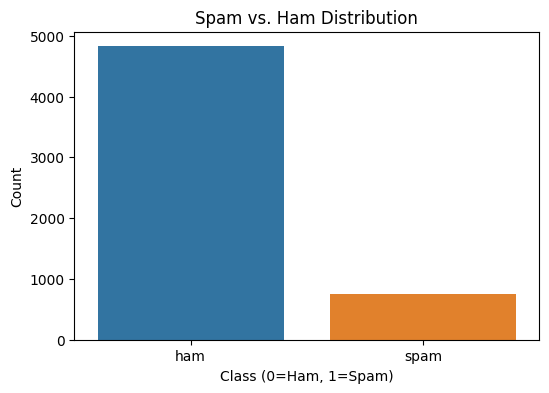

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=data)
plt.title("Spam vs. Ham Distribution")
plt.xlabel("Class (0=Ham, 1=Spam)")
plt.ylabel("Count")
plt.show()

In [8]:
X = data['text_clean']
y = data['label_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [11]:
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)


Accuracy: 0.9497757847533632

Confusion Matrix:
 [[961   4]
 [ 52  98]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       965
           1       0.96      0.65      0.78       150

    accuracy                           0.95      1115
   macro avg       0.95      0.82      0.87      1115
weighted avg       0.95      0.95      0.95      1115



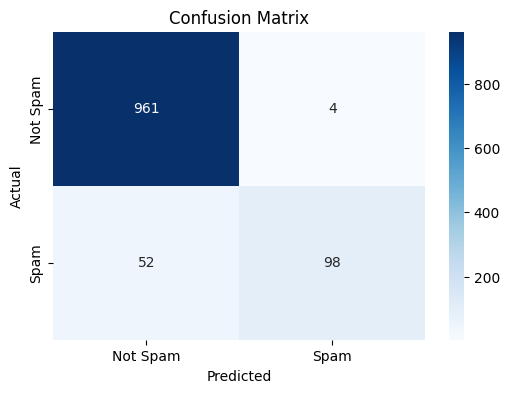

In [12]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam','Spam'], yticklabels=['Not Spam','Spam'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

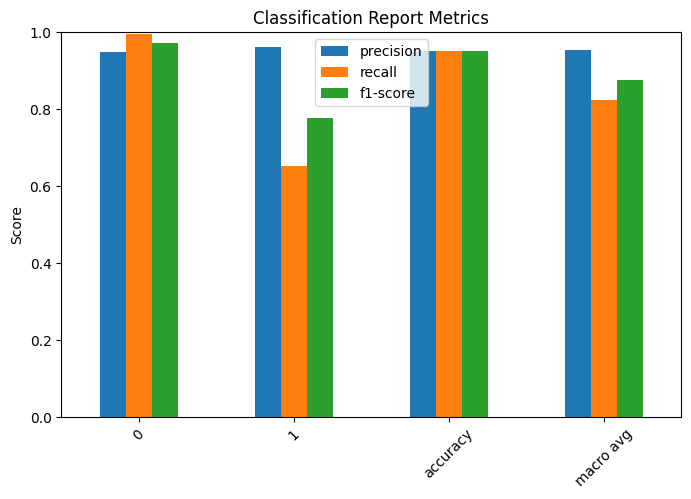

In [13]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df.iloc[:-1, :3].plot(kind='bar', figsize=(8,5))
plt.title('Classification Report Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.show()

In [14]:
with open('spam_classifier_model.pkl', 'wb') as file:
    pickle.dump(model, file)

with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

print("✅ Model and vectorizer saved successfully.")

✅ Model and vectorizer saved successfully.


In [ ]:
import joblib

# Load trained model and vectorizer
model = joblib.load("/kaggle/working/spam_classifier_model.pkl")
vectorizer = joblib.load("/kaggle/working/tfidf_vectorizer.pkl")

print("📧 Spam Detector Initialized!")
print("Type/paste your email text when prompted.")

# Prediction loop
while True:
    user_input = input("\nWould you like to predict a new email? (y/n): ").strip().lower()

    if user_input == 'n':
        print("Exiting the prediction loop. 👋")
        break

    elif user_input == 'y':
        try:
            email_text = input("Enter the email text: ").strip()

            if not email_text:
                print("❗Please enter some email text.")
                continue

            # Transform email
            email_vec = vectorizer.transform([email_text])
            prediction = model.predict(email_vec)[0]
            confidence = model.predict_proba(email_vec)[0][prediction]

            # Output result
            label = "Spam ❌" if prediction == 1 else "Not Spam ✅"
            print(f"\nPrediction: {label} (Confidence: {confidence:.2f})")

        except Exception as e:
            print(f"⚠️ An error occurred: {e}")

    else:
        print("Please enter 'y' or 'n' only.")


📧 Spam Detector Initialized!
Type/paste your email text when prompted.



Would you like to predict a new email? (y/n):  y
Enter the email text:  hi how are you



Prediction: Not Spam ✅ (Confidence: 0.95)



Would you like to predict a new email? (y/n):  hi!! budy whats up


Please enter 'y' or 'n' only.



Would you like to predict a new email? (y/n):  y
Enter the email text:  hi buddy whats up



Prediction: Not Spam ✅ (Confidence: 0.95)



Would you like to predict a new email? (y/n):  Congratulations! You've won a free iPhone. Click here to claim your prize now!


Please enter 'y' or 'n' only.



Would you like to predict a new email? (y/n):  y
Enter the email text:  Congratulations! You've won a free iPhone. Click here to claim your prize now!



Prediction: Spam ❌ (Confidence: 0.77)
